In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
import numpy as np
import seaborn as sns
from netgraph import Graph, InteractiveGraph
from pyvis.network import Network

## Production des données

* Requête exécutée sur le serveur https://dbpedia.org/sparql 
* Période élargie jusqu'aux comtemporains-nes
* Propriétés prises en compte après inspection des propriétés de la population:
  * http://dbpedia.org/ontology/almaMater 
  * http://dbpedia.org/ontology/institution


```SPARQL
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT (?o1 AS ?subject_uri) ?subjectBirthDate ?r_property  ?target 
# (COUNT(*) AS ?effectif) 
WHERE {
  SELECT DISTINCT ?o1 ?subjectBirthDate ?r_property  ?target 
  WHERE { 
    {
          {dbr:List_of_astronomers ?p ?o1.}
      UNION
          {dbr:List_of_astrologers ?p ?o1.}
      UNION
          {?o1 ?p dbr:Astrologer.}
      UNION
          {?o1 ?p dbr:Astronomer.}
      UNION
          {?o1 ?p dbr:Mathematician.}
    }
    ?o1 a dbo:Person;
      dbp:birthDate | dbo:birthDate ?subjectBirthDate.
     {
        {?o1 dbo:almaMater ?target.
     BIND('almaMater' AS ?r_property) }
UNION  {?o1 dbo:institution ?target.
     BIND('institution' AS ?r_property) }
#UNION  {?o1 dbp:fields ?target.
#     BIND('fields' AS ?r_property) }
#UNION  {?o1 dbp:field ?target.
#     BIND('field' AS ?r_property) }
}

    BIND(xsd:integer(SUBSTR(STR(?subjectBirthDate), 1, 4)) AS ?birthYear)
    FILTER ( (?birthYear >= 1451   ))
 
          }
  ORDER BY ?birthYear
  }

```

In [2]:
### Ouvrir le fichier et créer un DataFrame
fd = 'data/dbpedia_sparql_relations.csv'
df = pd.read_csv(fd)
len(df)

7136

In [3]:
### Raccourcir l'URI, extraire l'année de naissance
df['subject_uri'] = df['subject_uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['target'] = df['target'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['BirthYear'] = df['subjectBirthDate'].apply(lambda x : int(x[:4]))

In [4]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'insitution' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 17) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 27), axis=1)
df['YEnd'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 28) if x['r_property'] == 'almaMater' else int(x['BirthYear'] + 64), axis=1)

In [5]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7136 entries, 0 to 7135
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subject_uri       7136 non-null   object
 1   subjectBirthDate  7136 non-null   object
 2   r_property        7136 non-null   object
 3   target            7136 non-null   object
 4   BirthYear         7136 non-null   int64 
 5   YBegin            7136 non-null   int64 
 6   YEnd              7136 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 390.4+ KB


In [6]:
### Inspecter la distribution des années de naissance et périodes
df.BirthYear.describe(),df.YBegin.describe(),df.YEnd.describe()

(count    7136.000000
 mean     1913.805914
 std        55.868705
 min      1454.000000
 25%      1899.000000
 50%      1926.000000
 75%      1947.000000
 max      1989.000000
 Name: BirthYear, dtype: float64,
 count    7136.000000
 mean     1935.056194
 std        56.453892
 min      1471.000000
 25%      1919.000000
 50%      1948.000000
 75%      1968.000000
 max      2015.000000
 Name: YBegin, dtype: float64,
 count    7136.000000
 mean     1957.106923
 std        59.889152
 min      1482.000000
 25%      1938.000000
 50%      1969.000000
 75%      1992.000000
 max      2052.000000
 Name: YEnd, dtype: float64)

In [7]:
# list(df.columns)

In [8]:
### https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
show(df[['subject_uri','r_property','target','YBegin','YEnd','BirthYear']].sort_values(by='BirthYear'), classes="display", scrollY="200px", 
     scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [9]:
### Compter par propriété
df.groupby(by='r_property').size()

r_property
almaMater      4103
institution    3033
dtype: int64

In [10]:
# l_org_orig = list(df.target.unique()); len(l_org_orig), l_org_orig[:3]

In [11]:
### Effectuer et documenter tous les changements: nettoyage des données
df.loc[df.target == 'École_normale_supérieure_(Ulm)', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_normale_supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Superieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'Swiss_Federal_Polytechnic', 'target']  = 'ETH_Zurich'
df.loc[df.target == 'Federal_Polytechnic_School', 'target']  = 'ETH_Zurich'
df.loc[df.target == 'Swiss_Federal_Institute_of_Technology_at_Zurich', 'target']  = 'ETH_Zurich'
df.loc[df.target == 'École_polytechnique', 'target']  = 'École_Polytechnique'
df.loc[df.target == 'University_of_Padua', 'target']  = 'Università_di_Padova'
df.loc[df.target == 'University_of_Padova', 'target']  = 'Università_di_Padova'

In [12]:
### Remplacements multiples, contenant Paris et Université
df.loc[(df.target.str.contains('Paris')) & (df.target.str.contains('Univ')), 'target'] = "Université_de_Paris"

In [13]:
organisations = df.groupby(by='target').size()
show(organisations.sort_index(ascending=False))

In [14]:
len(organisations), organisations.tail()

(1677,
 target
 École_normale_supérieure_(Paris)             79
 École_normale_supérieure_de_Lyon              2
 École_normale_supérieure_de_jeunes_filles     1
 École_supérieure_d'optique                    1
 Électricité_de_France                         1
 dtype: int64)

### Explorer les années de naissance

In [15]:
s = df.BirthYear

(1801.0, 1900.0)

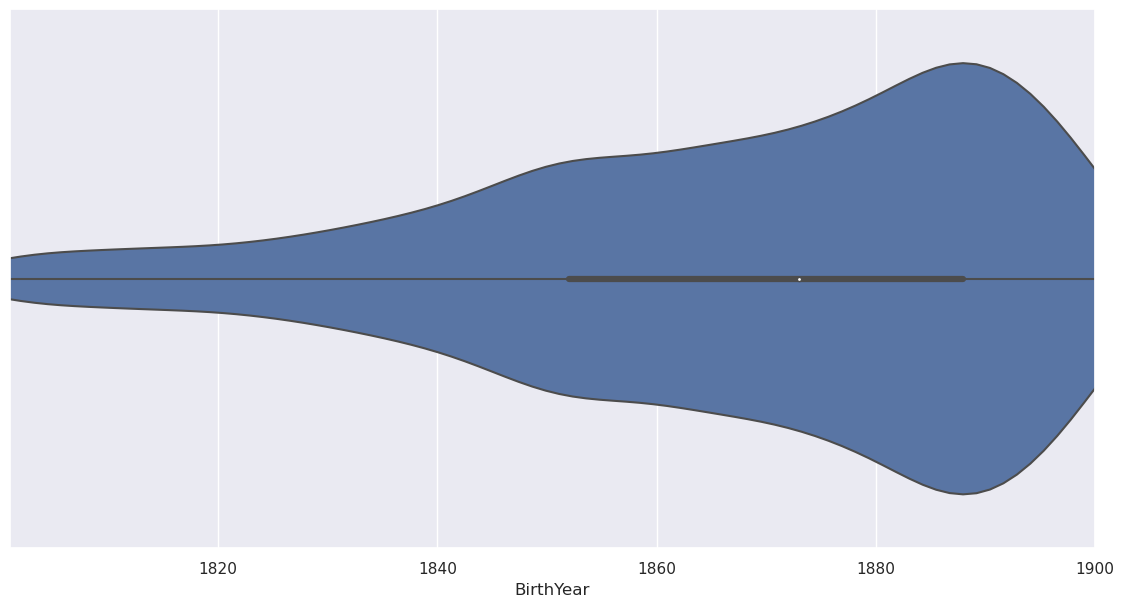

In [16]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

### Personnes nées avant 1931 (protection des données)
# a = s[(s<1931)] 
## Période pré-scientifique
a = s[(s<1801)]
## Décollage de la science 'moderne'
a = s[(s>1800) & (s<1901)] # 
## Science contemporaine
# a = s[(s>1900) ] # 
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


#### Coder les périodes

In [17]:
bins=[1001,1801,1901,2021]

In [18]:
df['periode'] = pd.cut(df['BirthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [19]:
df.head()

subject_uri subjectBirthDate r_property  \
0  Domenico_Maria_Novara_da_Ferrara       1454-08-01  almaMater   
1                Scipione_del_Ferro       1465-02-06  almaMater   
2        Heinrich_Cornelius_Agrippa       1486-09-14  almaMater   
3                    Michael_Stifel             1487  almaMater   
4                  Gerolamo_Cardano       1501-09-24  almaMater   

                     target  BirthYear  YBegin  YEnd    periode  
0    University_of_Florence       1454    1471  1482  1001_1801  
1     University_of_Bologna       1465    1482  1493  1001_1801  
2     University_of_Cologne       1486    1503  1514  1001_1801  
3  University_of_Wittenberg       1487    1504  1515  1001_1801  
4       University_of_Pavia       1501    1518  1529  1001_1801

In [20]:
df.groupby(by='periode').size()

periode
1001_1801     256
1801_1901    1578
1901_2021    5302
dtype: int64

In [21]:
### Dataframe to dictionary
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['subject_uri', 'r_property', 'target',
       'YBegin', 'YEnd', 'BirthYear', 'periode']].sort_values(by='subject_uri').to_dict('records')

In [22]:
ldf[:3]

[{'subject_uri': "'Mamphono_Khaketla",
  'r_property': 'almaMater',
  'target': 'University_of_Wisconsin',
  'YBegin': 1977,
  'YEnd': 1988,
  'BirthYear': 1960,
  'periode': '1901_2021'},
 {'subject_uri': 'A._E._Douglass',
  'r_property': 'almaMater',
  'target': 'Hartford',
  'YBegin': 1884,
  'YEnd': 1895,
  'BirthYear': 1867,
  'periode': '1801_1901'},
 {'subject_uri': 'A._E._Douglass',
  'r_property': 'almaMater',
  'target': 'Trinity_College_(Connecticut)',
  'YBegin': 1884,
  'YEnd': 1895,
  'BirthYear': 1867,
  'periode': '1801_1901'}]

## Graphe à deux types de sommets

In [23]:
l = []
for i in ldf:
    if i['periode'] == '1001_1801':
        l.append(tuple((i['subject_uri'],i['target'], 
                        {'relationship': i['r_property'], "birth_year": i['BirthYear'], "periode": i['periode'] })))
l[:5]

[('Abraham_de_Moivre',
  'Academy_of_Saumur',
  {'relationship': 'almaMater', 'birth_year': 1667, 'periode': '1001_1801'}),
 ('Adolphe_Quetelet',
  'University_of_Ghent',
  {'relationship': 'almaMater', 'birth_year': 1796, 'periode': '1001_1801'}),
 ('Adriaan_Metius',
  'University_of_Franeker',
  {'relationship': 'almaMater', 'birth_year': 1571, 'periode': '1001_1801'}),
 ('Adrien-Marie_Legendre',
  'Collège_Mazarin',
  {'relationship': 'almaMater', 'birth_year': 1752, 'periode': '1001_1801'}),
 ('Anders_Celsius',
  'Uppsala_University',
  {'relationship': 'almaMater', 'birth_year': 1701, 'periode': '1001_1801'})]

In [24]:
# Graphe Personne- Organisation
POG=nx.Graph()

In [25]:
POG.add_edges_from(l)

In [26]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
POG.is_multigraph(), POG.is_directed(), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)


(False, False, 313, 241, 0.004935692635373147)

In [27]:
l_org = list(organisations.index); len(l_org); l_org[:3]

['AT&T_Bell_Laboratories', 'AT&T_Labs', 'Aarhus_University']

In [28]:
list(POG.nodes.data())[:4]

[('Abraham_de_Moivre', {}),
 ('Academy_of_Saumur', {}),
 ('Adolphe_Quetelet', {}),
 ('University_of_Ghent', {})]

In [31]:
### Ajouter au sommets un code si personne ou organisation
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('Abraham_de_Moivre', {'type': 'P'}),
 ('Academy_of_Saumur', {'type': 'O'}),
 ('Adolphe_Quetelet', {'type': 'P'})]

In [32]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Abraham_de_Moivre', {'type': 'P'}),
 ('Academy_of_Saumur', {'type': 'O'}),
 ('Adolphe_Quetelet', {'type': 'P'})]

In [201]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [34]:
nx.set_node_attributes(POG, degree)

In [35]:
print(list(POG.nodes.data())[:4])

[('Abraham_de_Moivre', {'type': 'P', 'degree': 1}), ('Academy_of_Saumur', {'type': 'O', 'degree': 1}), ('Adolphe_Quetelet', {'type': 'P', 'degree': 1}), ('University_of_Ghent', {'type': 'O', 'degree': 1})]


In [36]:
edges = list(POG.edges.data())
edges[:5]

[('Abraham_de_Moivre',
  'Academy_of_Saumur',
  {'relationship': 'almaMater', 'birth_year': 1667, 'periode': '1001_1801'}),
 ('Adolphe_Quetelet',
  'University_of_Ghent',
  {'relationship': 'almaMater', 'birth_year': 1796, 'periode': '1001_1801'}),
 ('Adriaan_Metius',
  'University_of_Franeker',
  {'relationship': 'almaMater', 'birth_year': 1571, 'periode': '1001_1801'}),
 ('Adrien-Marie_Legendre',
  'Collège_Mazarin',
  {'relationship': 'almaMater', 'birth_year': 1752, 'periode': '1001_1801'}),
 ('Anders_Celsius',
  'Uppsala_University',
  {'relationship': 'almaMater', 'birth_year': 1701, 'periode': '1001_1801'})]

In [37]:
labels = {}    
for node in POG.nodes():
    labels[node] = node

In [38]:
nx.set_node_attributes(POG, labels, 'label')

In [39]:
nodes = list(POG.nodes.data())
nodes[:5]

[('Abraham_de_Moivre',
  {'type': 'P', 'degree': 1, 'label': 'Abraham_de_Moivre'}),
 ('Academy_of_Saumur',
  {'type': 'O', 'degree': 1, 'label': 'Academy_of_Saumur'}),
 ('Adolphe_Quetelet', {'type': 'P', 'degree': 1, 'label': 'Adolphe_Quetelet'}),
 ('University_of_Ghent',
  {'type': 'O', 'degree': 1, 'label': 'University_of_Ghent'}),
 ('Adriaan_Metius', {'type': 'P', 'degree': 1, 'label': 'Adriaan_Metius'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [40]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(75, [24, 22, 17, 15, 14])

In [41]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [42]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[14, 24], [8, 22], [18, 17], [15, 15], [31, 14], [17, 12], [6, 11], [21, 10]]

In [57]:
li=[n[0] for n in ln]

In [43]:
S[21].nodes 

NodeView(('University_of_Cambridge', 'Jeremiah_Horrocks', 'Isaac_Newton', 'Royal_Mint', 'Christopher_Heydon', 'Royal_Society', 'Isaac_Milner', 'Peterhouse,_Cambridge', 'Josef_de_Mendoza_y_Ríos', 'William_Hopkins'))

### Représenter le graphe

In [44]:
u = S[14]

In [58]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [59]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(s)


(False, False, 92, 89, 0.08333333333333333)

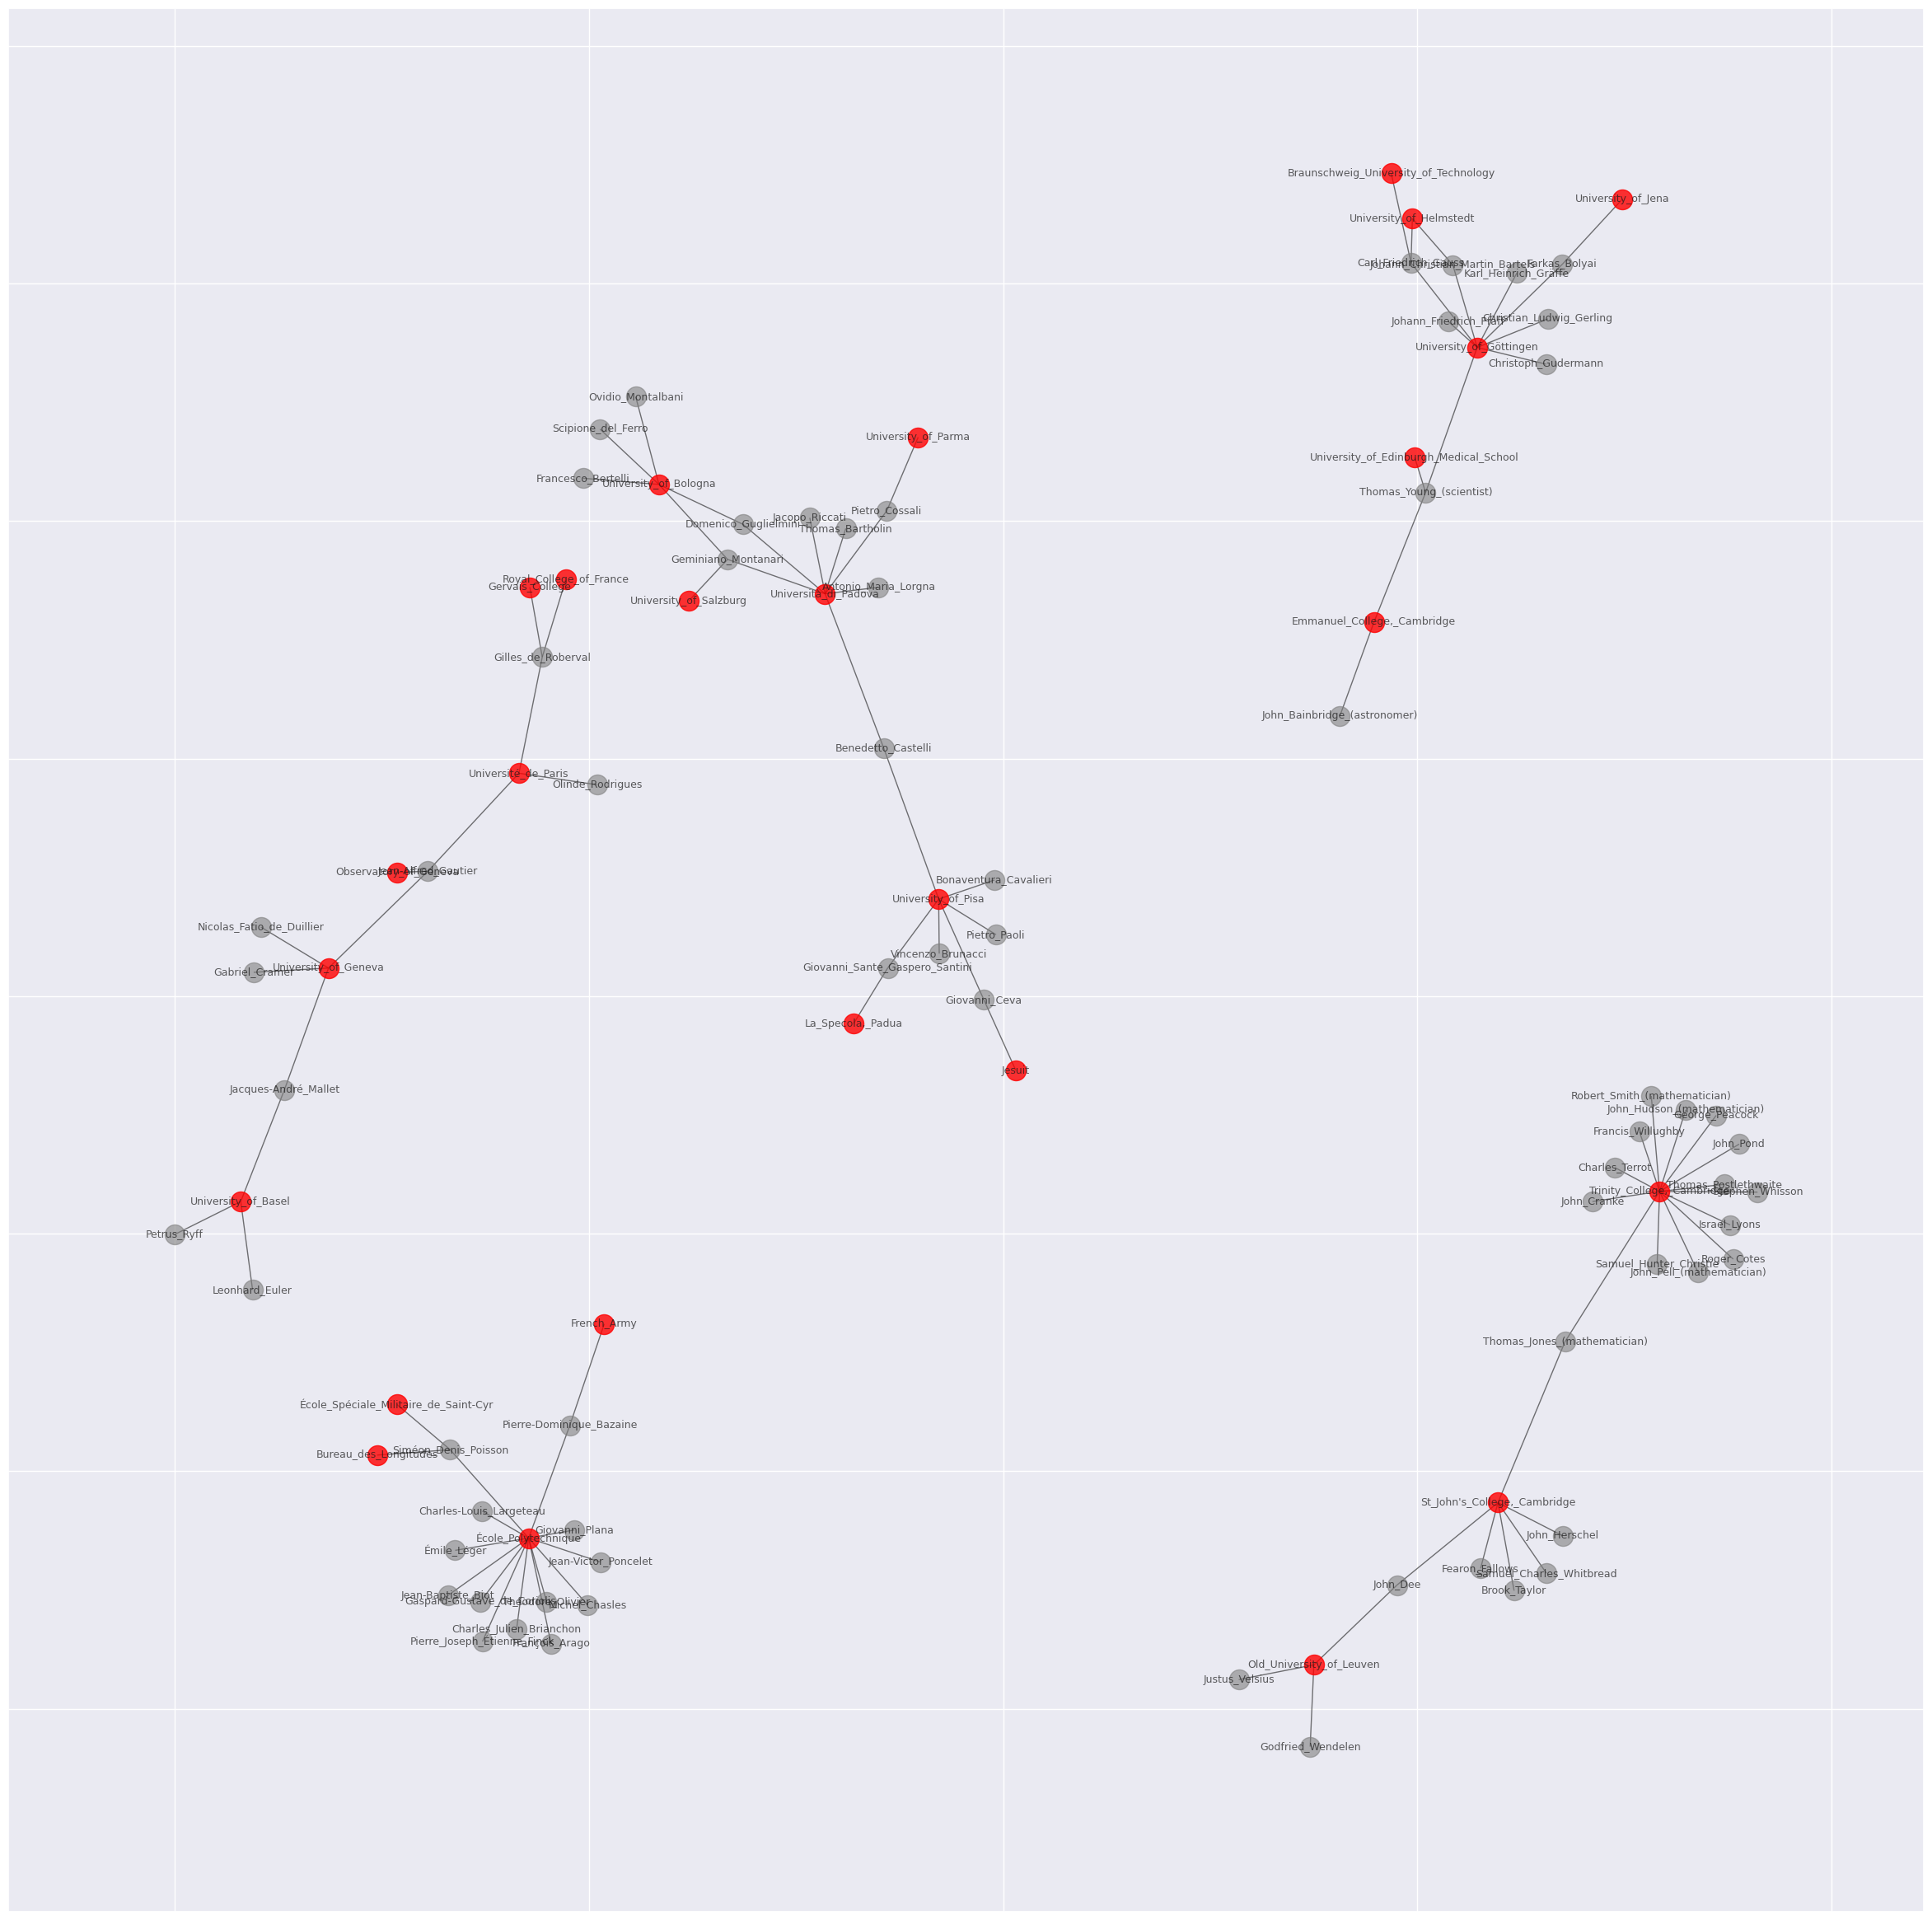

In [69]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()


In [70]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(g)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [63]:
nt.prep_notebook()
nt.show('pictures/nx.html' )

### Créer les paires de personnes

In [107]:
## Pairs de personnes
pairs_p = []

for s1 in ldf:
    for s2 in ldf:
        if s1['subject_uri'] < s2['subject_uri'] \
            and s1['target'] == s2['target'] \
            and s2['YEnd'] >= s1['YBegin'] \
            and s2['YBegin'] <= s1['YEnd']:
            pairs_p.append([s1,s2])
        else:
            pass

In [108]:
len(pairs_p)

49597

In [109]:
pairs_p[:2]

[[{'subject_uri': "'Mamphono_Khaketla",
   'r_property': 'almaMater',
   'target': 'University_of_Wisconsin',
   'YBegin': 1977,
   'YEnd': 1988,
   'BirthYear': 1960,
   'periode': '1901_2021'},
  {'subject_uri': 'Marvin_Knopp',
   'r_property': 'institution',
   'target': 'University_of_Wisconsin',
   'YBegin': 1960,
   'YEnd': 1997,
   'BirthYear': 1933,
   'periode': '1901_2021'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'Carl_S._Herz',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1957,
   'YEnd': 1994,
   'BirthYear': 1930,
   'periode': '1901_2021'}]]

### Créer les pairs d'organisations

In [110]:
## Pairs d'organisations
pairs_o = []

for s1 in ldf:
    for s2 in ldf:
        if s1['target'] < s2['target'] \
            and s1['subject_uri'] == s2['subject_uri']:
                pairs_o.append([s1,s2])
        else:
            pass

In [111]:
len(pairs_o)

8338

In [75]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Hartford',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'},
  {'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Trinity_College_(Connecticut)',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'A._M._Mathai',
   'r_property': 'almaMater',
   'target': 'Palai',
   'YBegin': 1952,
   'YEnd': 1963,
   'BirthYear': 1935,
   'periode': '1901_2021'}]]

## Réseaux de personnes

In [112]:
earlyModern_pairs = [p for p in pairs_p if ((p[0]['periode']=='1001_1801') & (p[1]['periode']=='1001_1801'))]

In [113]:
len(earlyModern_pairs), earlyModern_pairs[:3]

(153,
 [[{'subject_uri': 'Andreas_von_Ettingshausen',
    'r_property': 'institution',
    'target': 'University_of_Vienna',
    'YBegin': 1823,
    'YEnd': 1860,
    'BirthYear': 1796,
    'periode': '1001_1801'},
   {'subject_uri': 'Joseph_Johann_von_Littrow',
    'r_property': 'institution',
    'target': 'University_of_Vienna',
    'YBegin': 1808,
    'YEnd': 1845,
    'BirthYear': 1781,
    'periode': '1001_1801'}],
  [{'subject_uri': 'Andreas_von_Ettingshausen',
    'r_property': 'institution',
    'target': 'University_of_Vienna',
    'YBegin': 1823,
    'YEnd': 1860,
    'BirthYear': 1796,
    'periode': '1001_1801'},
   {'subject_uri': 'Nikolai_Brashman',
    'r_property': 'almaMater',
    'target': 'University_of_Vienna',
    'YBegin': 1813,
    'YEnd': 1824,
    'BirthYear': 1796,
    'periode': '1001_1801'}],
  [{'subject_uri': 'Andreas_von_Ettingshausen',
    'r_property': 'institution',
    'target': 'Vienna_University_of_Technology',
    'YBegin': 1823,
    'YEnd': 1860,

In [116]:
almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'almaMater') & (p[1]['r_property'] == 'almaMater'))]

In [117]:
len(almaMater_pairs), almaMater_pairs[:3]

(15422,
 [[{'subject_uri': 'A._O._L._Atkin',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1942,
    'YEnd': 1953,
    'BirthYear': 1925,
    'periode': '1901_2021'},
   {'subject_uri': 'Abdus_Salam',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1943,
    'YEnd': 1954,
    'BirthYear': 1926,
    'periode': '1901_2021'}],
  [{'subject_uri': 'A._O._L._Atkin',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1942,
    'YEnd': 1953,
    'BirthYear': 1925,
    'periode': '1901_2021'},
   {'subject_uri': 'Anthony_James_Merrill_Spencer',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1946,
    'YEnd': 1957,
    'BirthYear': 1929,
    'periode': '1901_2021'}],
  [{'subject_uri': 'A._O._L._Atkin',
    'r_property': 'almaMater',
    'target': 'University_of_Cambridge',
    'YBegin': 1942,
    'YEnd': 1953,
    'BirthYear': 1925,
    'periode

## Exploration des graphes de personnes

In [118]:
l = []
for i in earlyModern_pairs: #almaMater_pairs:
    l.append(tuple((i[0]['subject_uri'],i[1]['subject_uri'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'organisation': i[0]['target'] })))
l[:5]

[('Andreas_von_Ettingshausen',
  'Joseph_Johann_von_Littrow',
  {'relationship': 'institution_institution',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'institution_almaMater',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'institution_almaMater',
   'organisation': 'Vienna_University_of_Technology'}),
 ('Andreas_von_Ettingshausen',
  'Joseph_Johann_von_Littrow',
  {'relationship': 'almaMater_institution',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Vienna'})]

In [119]:
EMP=nx.Graph()

In [120]:
EMP.add_edges_from(l)

In [121]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
EMP.is_multigraph(), EMP.is_directed(), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP)


(False, False, 76, 130, 0.0456140350877193)

In [122]:
nodes = list(EMP.nodes.data())
nodes[:5]

[('Andreas_von_Ettingshausen', {}),
 ('Joseph_Johann_von_Littrow', {}),
 ('Nikolai_Brashman', {}),
 ('Antonio_Maria_Bordoni', {}),
 ('Gabrio_Piola', {})]

In [123]:
edges = list(EMP.edges.data())
edges[:5]

[('Andreas_von_Ettingshausen',
  'Joseph_Johann_von_Littrow',
  {'relationship': 'almaMater_institution',
   'organisation': 'University_of_Vienna'}),
 ('Andreas_von_Ettingshausen',
  'Nikolai_Brashman',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Vienna'}),
 ('Joseph_Johann_von_Littrow',
  'Nikolai_Brashman',
  {'relationship': 'institution_almaMater',
   'organisation': 'University_of_Vienna'}),
 ('Antonio_Maria_Bordoni',
  'Gabrio_Piola',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'University_of_Pavia'}),
 ('Archibald_Alexander',
  'Joseph_Caldwell',
  {'relationship': 'almaMater_almaMater',
   'organisation': 'Princeton_University'})]

In [124]:
labels = {}    
for node in EMP.nodes():
    labels[node] = node

In [125]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(EMP)
nt.prep_notebook()
nt.show('pictures/emp.html' )

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [126]:
components = nx.connected_components(EMP);
components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
len(components_l), components_l[:5]

(23, [13, 12, 8, 3, 3])

In [127]:
S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [128]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[6, 13], [7, 12], [5, 8], [0, 3], [10, 3], [13, 3], [1, 2], [2, 2]]

In [129]:
li=[n[0] for n in ln]

### Représenter le graphe

In [170]:
u = nx.Graph()
for i in li[1:3]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [171]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(s)


(False, False, 20, 41, 0.08333333333333333)

In [168]:
u = S[5]

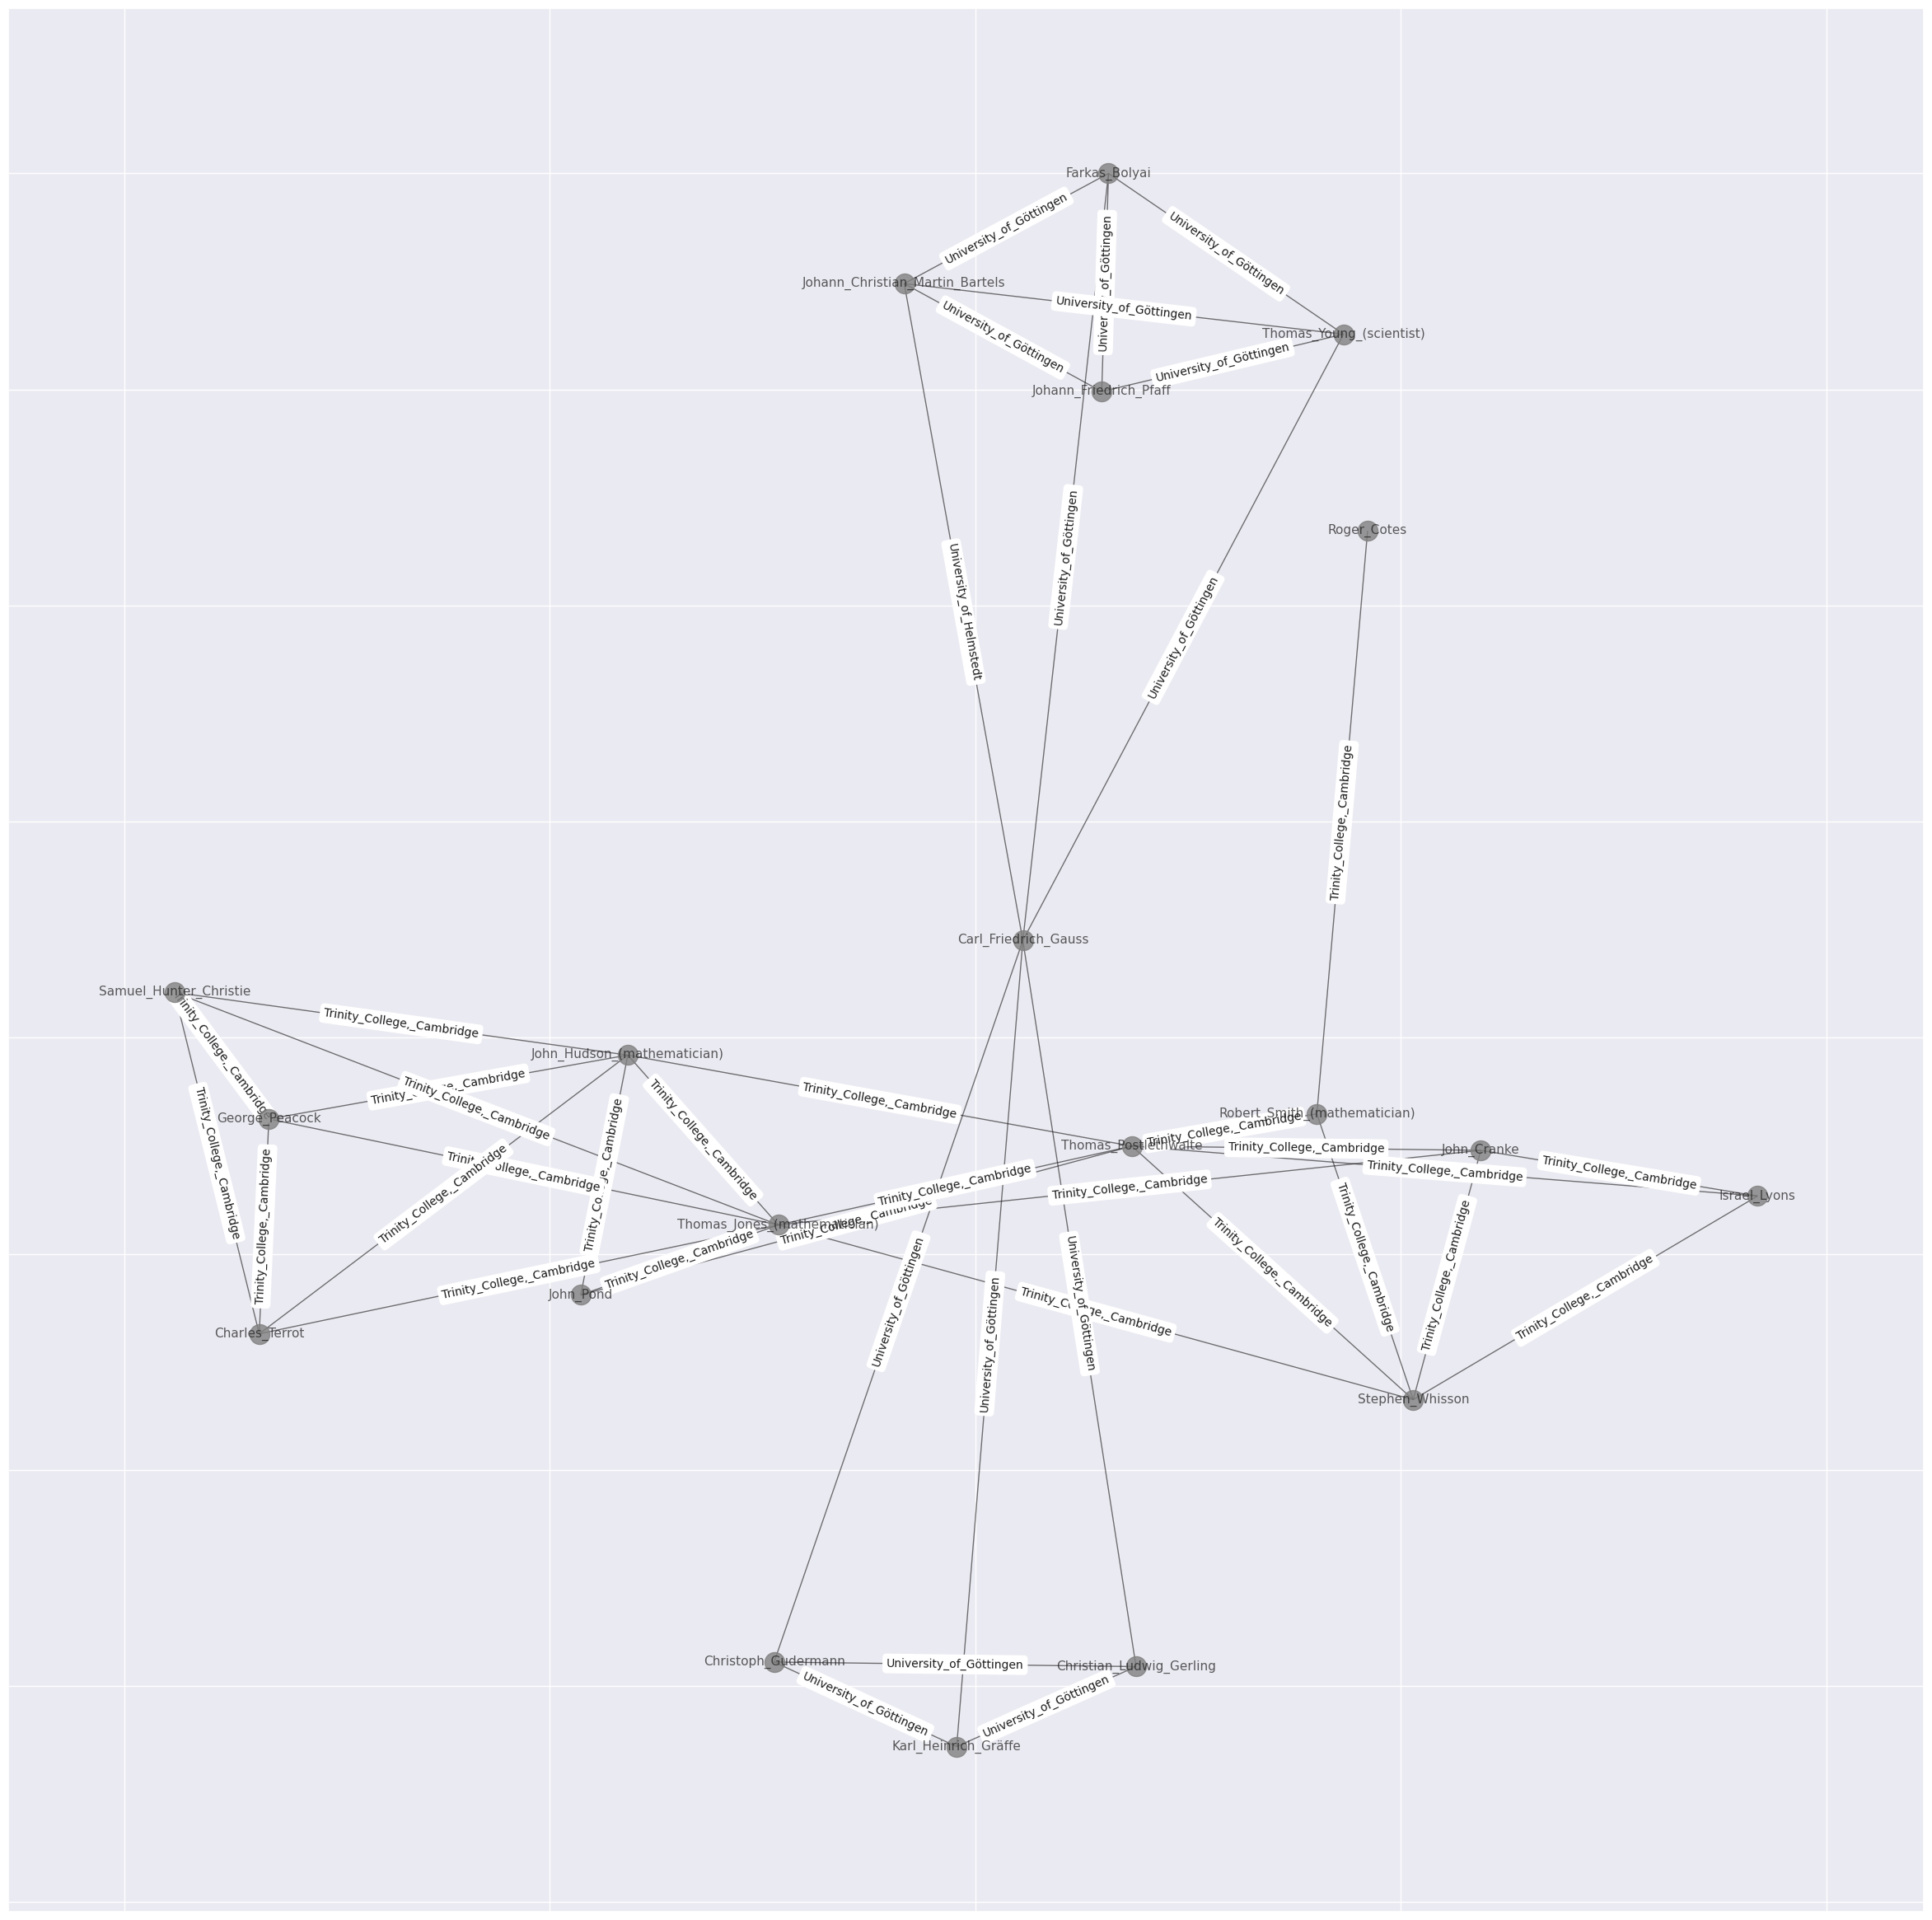

In [179]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)



plt.show()


## Explorer le graphe des organisations (relation Alma Mater)

In [180]:
### Apparaissent des parcours de vie
pairs_o[:2]

[[{'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Hartford',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'},
  {'subject_uri': 'A._E._Douglass',
   'r_property': 'almaMater',
   'target': 'Trinity_College_(Connecticut)',
   'YBegin': 1884,
   'YEnd': 1895,
   'BirthYear': 1867,
   'periode': '1801_1901'}],
 [{'subject_uri': 'A._M._Mathai',
   'r_property': 'institution',
   'target': 'McGill_University',
   'YBegin': 1962,
   'YEnd': 1999,
   'BirthYear': 1935,
   'periode': '1901_2021'},
  {'subject_uri': 'A._M._Mathai',
   'r_property': 'almaMater',
   'target': 'Palai',
   'YBegin': 1952,
   'YEnd': 1963,
   'BirthYear': 1935,
   'periode': '1901_2021'}]]

In [186]:
l = []
for i in pairs_o:
    if i[0]['r_property'] == 'almaMater' or  i[1]['r_property'] == 'almaMater':
        l.append(tuple((i[0]['target'],i[1]['target'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              'personne': i[0]['subject_uri'] })))
len(l), l[:3]        

(5176,
 [('Hartford',
   'Trinity_College_(Connecticut)',
   {'relationship': 'almaMater_almaMater', 'personne': 'A._E._Douglass'}),
  ('McGill_University',
   'Palai',
   {'relationship': 'institution_almaMater', 'personne': 'A._M._Mathai'}),
  ('Bletchley_Park',
   'University_of_Cambridge',
   {'relationship': 'institution_almaMater', 'personne': 'A._O._L._Atkin'})])

In [188]:
amO=nx.Graph()

In [189]:
amO.add_edges_from(l)

In [190]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
amO.is_multigraph(),nx.is_connected(amO) , amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO)


(False, False, 1443, 4027, 0.003870615521100958)

In [191]:
nodes = list(amO.nodes.data())
nodes[:5]

[('Hartford', {}),
 ('Trinity_College_(Connecticut)', {}),
 ('McGill_University', {}),
 ('Palai', {}),
 ('Bletchley_Park', {})]

In [192]:
edges = list(amO.edges.data())
edges[:5]

[('Hartford',
  'Trinity_College_(Connecticut)',
  {'relationship': 'almaMater_almaMater', 'personne': 'A._E._Douglass'}),
 ('McGill_University',
  'Palai',
  {'relationship': 'institution_almaMater', 'personne': 'A._M._Mathai'}),
 ('McGill_University',
  'Princeton_University',
  {'relationship': 'institution_almaMater', 'personne': 'Carl_S._Herz'}),
 ('McGill_University',
  'Cornell_University',
  {'relationship': 'almaMater_almaMater', 'personne': 'Hubert_Reeves'}),
 ('McGill_University',
  'Centre_de_Recherches_Mathématiques',
  {'relationship': 'institution_almaMater', 'personne': 'David_Sankoff'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [195]:
components = nx.connected_components(amO);
components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
len(components_l), components_l[:5]

(29, [1367, 6, 6, 4, 4])

In [196]:
largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

set

In [197]:
S = amO.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

In [198]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)


(False, True, 1367, 3968, 0.004249936540136088)

### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [201]:
# On construit ici le dictionnaire selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [202]:
nx.set_node_attributes(amO, degree)
print(list(amO.nodes.data())[:3])

[('Hartford', {'size': 10}), ('Trinity_College_(Connecticut)', {'size': 10}), ('McGill_University', {'size': 10, 'degree': 19})]


### Centralité de proximité

Compute [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) for nodes.


In [204]:
closeness = nx.closeness_centrality(amO)

In [205]:
nx.set_node_attributes(amO, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [206]:
betweenness = nx.betweenness_centrality(amO)

In [208]:
nx.set_node_attributes(amO, betweenness, 'betweenness')


In [234]:
### Exporter les attributs vers un DataFrame afin de les explorer
export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
export.head()

id  \
0                       Hartford   
1  Trinity_College_(Connecticut)   
2              McGill_University   
3                          Palai   
4                 Bletchley_Park   

                                          attributes  
0  {'size': 10, 'closeness': 0.000693481276005547...  
1  {'size': 10, 'closeness': 0.000693481276005547...  
2  {'size': 10, 'degree': 19, 'closeness': 0.3194...  
3  {'size': 10, 'degree': 1, 'closeness': 0.23892...  
4  {'size': 10, 'degree': 3, 'closeness': 0.29078...

In [235]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f


round(attributes, 3)

size  closeness  betweenness  degree
0       10      0.001          0.0     NaN
1       10      0.001          0.0     NaN
2       10      0.319         0.01    19.0
3       10      0.239          0.0     1.0
4       10      0.291          0.0     3.0
...    ...        ...          ...     ...
1438    10       0.31          0.0    12.0
1439    10       0.31          0.0    12.0
1440    10       0.31          0.0    12.0
1441    10      0.245          0.0     1.0
1442    10      0.266          0.0     1.0

[1443 rows x 4 columns]

In [236]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
export = export.join(pd.json_normalize(export.attributes)).set_index('id')
export.drop(columns=['attributes', 'size'], inplace=True)

In [237]:
round(export.sort_values(by=['degree'], ascending=False),3)

closeness  betweenness  degree
id                                                                         
University_of_Cambridge                          0.416        0.154   171.0
Harvard_University                                0.42        0.104   153.0
Princeton_University                             0.427        0.102   147.0
University_of_Chicago                            0.408         0.08   125.0
University_of_California,_Berkeley               0.398        0.065   108.0
...                                                ...          ...     ...
Tokyo_Bunri_University                           0.001          0.0     NaN
Cochin_University_of_Science_and_Technology      0.002          0.0     NaN
Kerala_University                                0.002          0.0     NaN
Madurai_Kamaraj_University                       0.002          0.0     NaN
Kothamangalam                                    0.002          0.0     NaN

[1443 rows x 3 columns]

In [242]:
export['degree'].describe()

count                1367.0
mean     5.8054133138258965
std      12.525880672974072
min                     1.0
25%                     1.0
50%                     2.0
75%                     5.0
max                   171.0
Name: degree, dtype: float64

(1.0, 171.0)

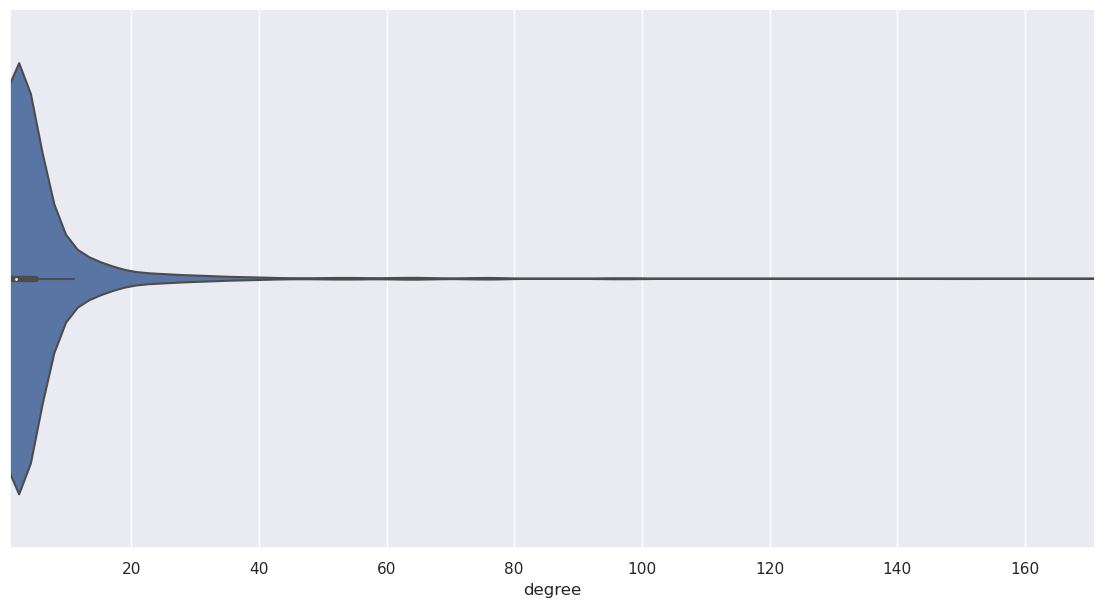

In [241]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

sns.set_theme(style="whitegrid")

sns.set(rc={"figure.figsize":(14, 7)})

a = export['degree'].dropna()
lim_left=min(a)
lim_right=max(a)





ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=lim_left, right=lim_right)


In [249]:
kamo = nx.k_core(amO, k=4)

In [250]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)


(False, False, 394, 2297, 0.029668952868084887)

In [251]:
components = nx.connected_components(kamo);
components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
len(components_l), components_l[:5]

(2, [389, 5])

In [252]:
largest_cc = max(nx.connected_components(kamo), key=len)

In [253]:
S = kamo.subgraph(largest_cc).copy()
type(S)


networkx.classes.graph.Graph

### Représenter le graphe

In [256]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html
u = S
## ,nx.is_connected(G_1971_1975) u.is_directed(),
u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(s)


(False, True, 389, 2287, 0.08333333333333333)

In [262]:
list(u.nodes.data())[1:3]

[('Bell_Labs',
  {'size': 10,
   'degree': 7,
   'closeness': 0.3180156175596481,
   'betweenness': 0.00010980117875227188}),
 ('Swarthmore_College',
  {'size': 10,
   'degree': 15,
   'closeness': 0.325290484628006,
   'betweenness': 0.0012657260750107422})]

In [287]:
labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 15:
        labels[i[0]]=i[0] 
list(labels.items())[:3]

[('University_of_Leipzig', 'University_of_Leipzig'),
 ('University_of_Kiel', 'University_of_Kiel'),
 ('Peking_University', 'Peking_University')]

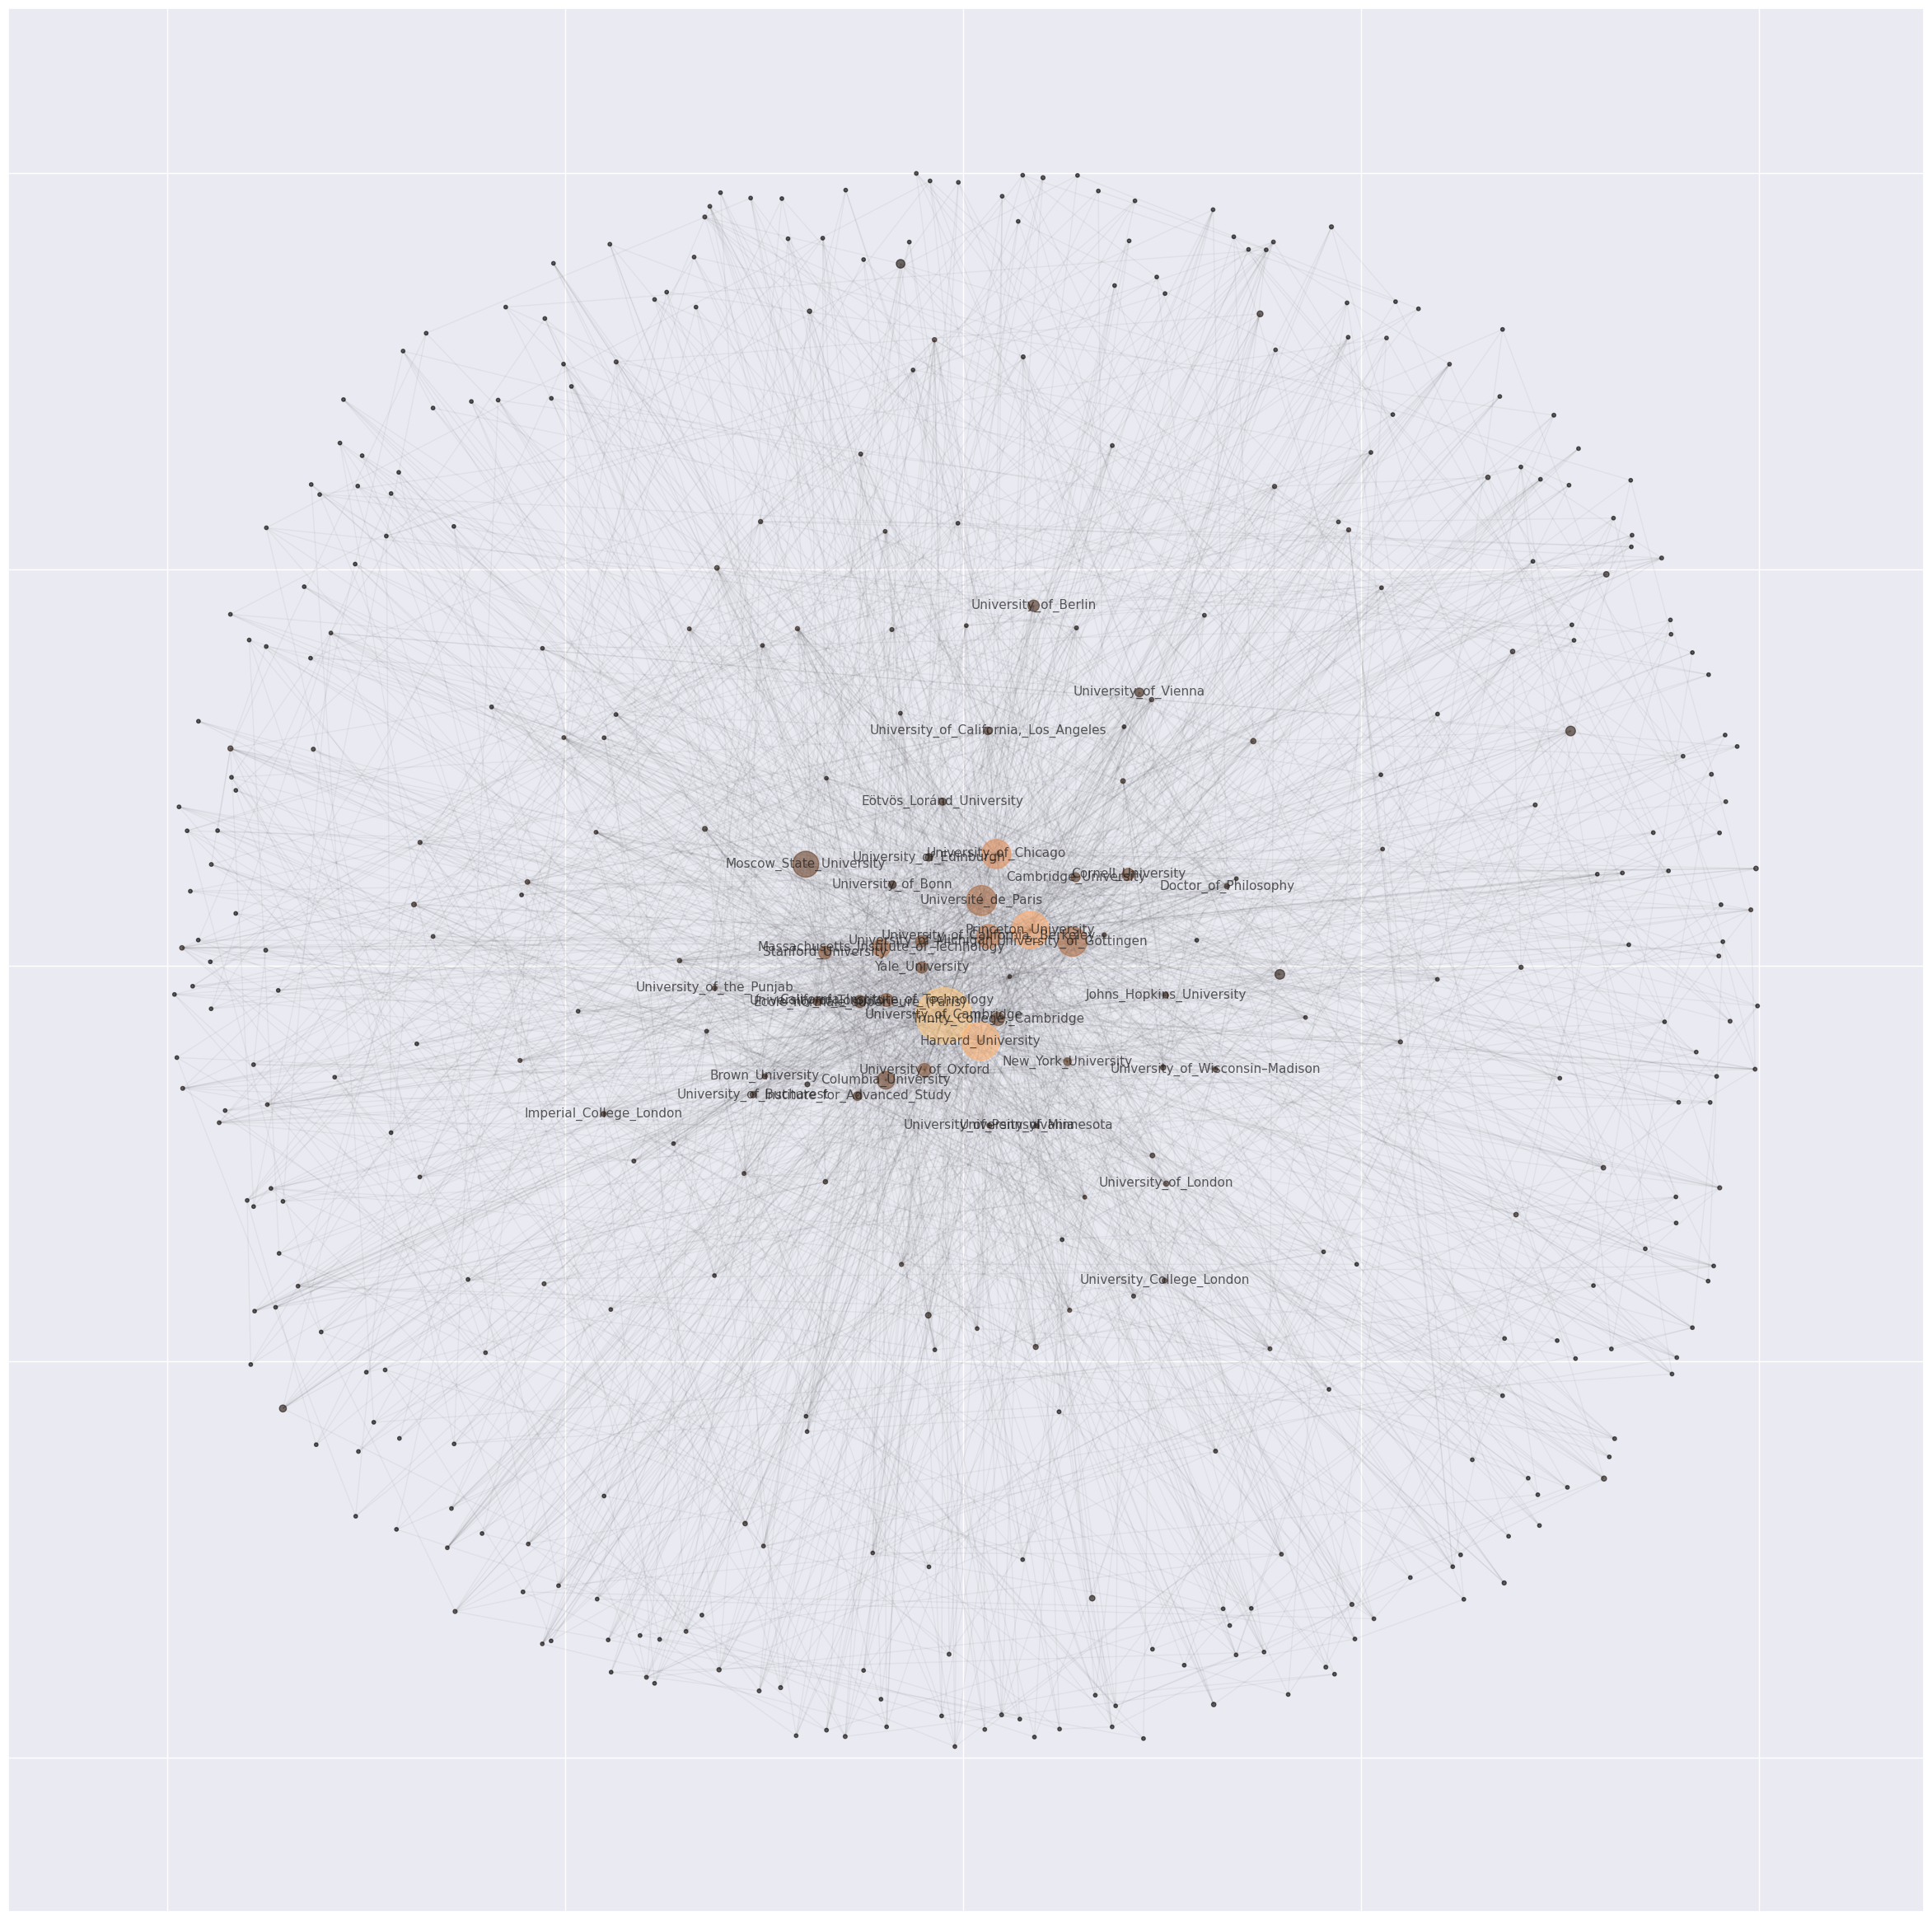

In [290]:
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(g, k=1)

labels = {}
for i in list(u.nodes.data()):
    if i[1]['degree'] > 30:
        labels[i[0]]=i[0] 

node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
node_sizes = [i[1]['betweenness']**2 * 100000 + 10 for i in list(u.nodes.data())]


cp = 'grey'
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color, 
                      cmap='copper', alpha=0.6)
nx.draw_networkx_edges(g, pos, alpha=0.05) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

f = 'pictures/universites.svg'# io.BytesIO()

plt.savefig(f, format="svg")

plt.show()
